In [1]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

In [2]:
# # Nature Video # #

# load up the in-silico responses as a pandas dataframe from a numpy array # (104171, 5000)
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))
# this array has 104171 units and 5000 time points

(104171,)


Text(0, 0.5, 'units')

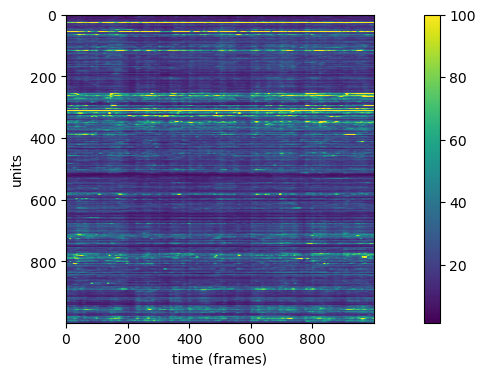

In [3]:
# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))
units_df[['scan_idx', 'scan_session']].value_counts()
# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

print(units_df['row_idx'].shape)
# plot the reponses as a heatmap
f, ax = plt.subplots(figsize=(13,4))
# lets just plot the first 1000 units and first 1000 timepoints
m=ax.imshow(resp.iloc[0:1000,0:1000], vmax=100)
f.colorbar(m)
ax.set_xlabel('time (frames)')
ax.set_ylabel('units')

Text(0, 0.5, 'units')

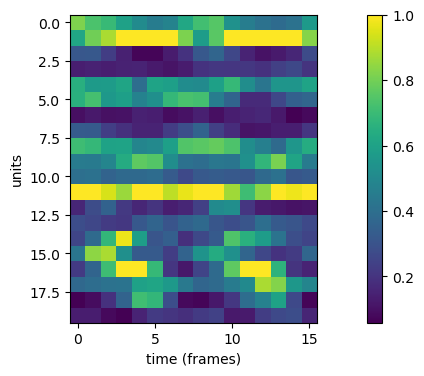

In [13]:
# # Monet Video # #

# load up the in-silico responses as a pandas dataframe from a numpy array # (16, 104171, 120)
monet_resp_filedata = np.load(os.path.join(data_dir, 'monet_resp.npy'))
resp_monet_dir = pd.DataFrame(monet_resp_filedata[:,:,0].T) # select one trial: (104171, 16)

# load up the csv of metadata about the 104171 units
# columns=[animal_id, scan_session, scan_idx, unit_id]
units_df_monet = pd.read_csv(os.path.join(data_dir, 'monet_unit.csv'))

# # ??
resp_monet_dir[['unit_id', 'scan_idx', 'scan_session']] = units_df_monet[['unit_id', 'scan_idx', 'scan_session']]

# plot the reponses as a heatmap
f, ax = plt.subplots(figsize=(13,4))
m=ax.imshow(resp_monet_dir.iloc[0:20,0:16], vmax=1)
f.colorbar(m)
ax.set_xlabel('time (frames)')
ax.set_ylabel('units')

In [14]:
# # Coregistration # #
# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

client.materialize.get_tables()
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

In [17]:
# # Coregistration with Monet siumili# #

coreg_in_silico_monet = pd.merge(resp_monet_dir , coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])

(12094, 36)

In [18]:
print(resp_monet_dir.shape)
print(coreg_df.shape)
print(coreg_in_silico_monet.shape)

(104171, 19)
(13925, 19)
(12094, 36)


Text(0, 0.5, 'unit 2')

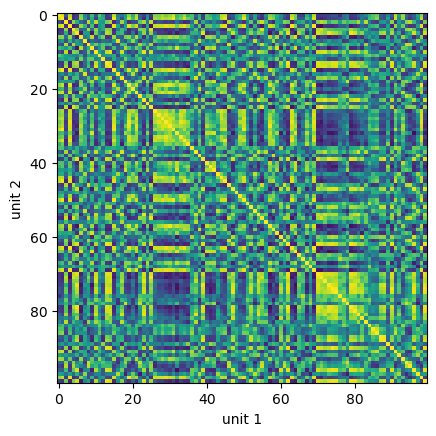

In [23]:
# select the coregistered neurons, now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M_monet = np.corrcoef(coreg_in_silico_monet[range(16)].values[:100])
# lets plot the structure
f, ax =plt.subplots()
ax.imshow(corr_M_monet, vmin=-1, vmax=1)
ax.set_xlabel('unit 1')
ax.set_ylabel('unit 2')

#what is the target_id/nucleus_id of the 5000 row of this matrix?
# coreg_in_silico_monet.query('index==5000')

# corr_df_monet = pd.DataFrame(corr_M_monet, index= coreg_resp_monet.index, columns = coreg_resp_monet.index) 
# corr_df_monet.head()

In [24]:
corr_M_monet.shape

(100, 100)

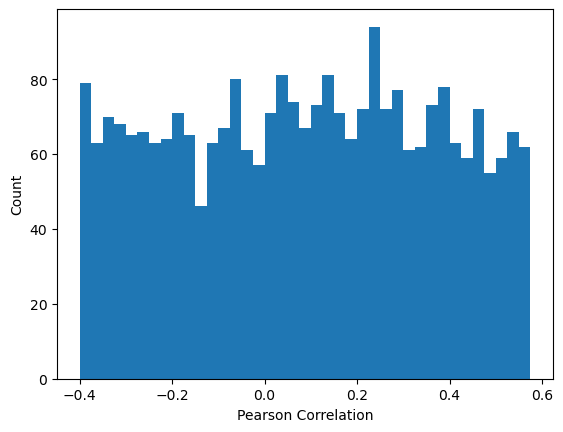

(0.006131337549495907, 0.5149781853653261)

In [26]:
# First thing to do, lets just look at the distribution of correlations

# we only want the upper triangle of the correlation matrix, 
# excluding the diagonal because Pearson correlation of yourself is by definiton 1.
# excluding the lower triangle because Pearson correlation is symettric. 
Cbins = np.arange(-.4,.6,.025)

# this pulls out only the upper trianglur indices from a matrix
# avoiding the diagonal and double counting i vs j, and j vs i. 
Cvals = corr_M_monet[np.triu_indices_from(corr_M_monet,1)]
plt.hist(Cvals, bins=Cbins)
plt.xlabel('Pearson Correlation')
plt.ylabel('Count')
plt.show()
np.mean(Cvals), np.std(Cvals)

In [27]:
# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})

# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico_monet, on='pt_root_id')

# we need this code to work in solutions directory and one up..
if 'solutions' in os.getcwd():
    workshop2file = '../../workshop2/all_prf_coreg_conn_v661.pkl'
else:
    workshop2file = '../workshop2/all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections
# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses
# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico_monet[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico_monet[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M_monet[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]




FileNotFoundError: [Errno 2] No such file or directory: '../workshop2/all_prf_coreg_conn_v661.pkl'

In [ ]:
# # cell types # #

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
ct_df.head()
ct_df.cell_type.value_counts().sort_index()
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')
# lets look at a subset of these columns to understand what we have now
ct_merge_df[['index','session', 'scan_idx', 'field', 'cell_type', 'pt_root_id', 'target_id', 'pt_position']].head()
# have lost some few cells that we don't have cell types for
ct_merge_df.shape
# Lets pick out the cells of particular type
# this is what row of the correlation matrix they are in 
l2index=ct_merge_df.query('cell_type=="L2a"')['index']
l2index
# pull out the values in the correlation matrix for this
# we want only the rows of that index, but all the columns
# and then we filter only those columns, but all the rows
tempc= corr_M[l2index, :][:,l2index]
# plot the distribution of correlations of within the L2a's vs 
# all the cells
import matplotlib.pyplot as plt
plt.hist(tempc[np.triu_indices_from(tempc,1)], bins=Cbins, density=True, histtype='step')
plt.hist(corr_M[np.triu_indices_from(corr_M,1)], bins=Cbins,density=True, histtype='step')
plt.legend(['L2a-L2a corr', 'all cell-cell corr'])
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()


In [ ]:
# # Connectivity # #

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')
clean_coreg_df.shape
# lets get the subset of the correlation matrix from these neurons
corr_M[clean_coreg_df['index'].values,:].shape

# lets load some connectivity data
try:
    all_syn_df = pd.read_pickle('all_prf_coreg_conn_v661.pkl')
except FileNotFoundError:
    all_syn_df = pd.read_pickle('../all_prf_coreg_conn_v661.pkl')
# see DownloadPrfCoregOutputs for details on where this data came from
# which is basically this code snippet below
# Let's download a summary of all the connections from these neurons to other neurons
# takes about 20 minutes to download the 160K connections
# synapse_dfs = {}
# for k, row in tqdm.tqdm_notebook(clean_coreg_df.iterrows(), total=len(clean_coreg_df)):
#     if synapse_dfs.get(row.pt_root_id, None) is None:
#         syn_df= client.materialize.query_view('connections_with_nuclei', filter_equal_dict={'pre_pt_root_id':row.pt_root_id})
#         synapse_dfs[row.pt_root_id]=syn_df
# for root_id in synapse_dfs:
#     synapse_dfs[root_id].attrs={}
# all_syn_df = pd.concat([synapse_dfs[k] for k in synapse_dfs])
# all_syn_df=all_syn_df.query('pre_nuc_id!=post_nuc_id')

# nice to just have a list of all the nuclei and their positions
# I'm just going to pull out 3 columns that we need
# note this asks for positions in units of microns (1000nm per unit in x,y,z)
nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])
nuc_df.head()

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)
# now we have positions for the pre and post cells
all_syn_dfm.head()

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]

# Lets look at the distribution of these correlations compared to all correlations
Cbins = np.arange(-.4,.6,.025)
plt.hist(all_syn_dfm2.C, bins=Cbins, density=True, linewidth=5,histtype='step', label='connected')
plt.hist(corr_M[np.triu_indices_from(corr_M,1)], linewidth=5, bins=Cbins,color='k',density=True, histtype='step', label='all')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()

# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])

# lets look at our dataframe for the columns we care most about
all_syn_dfm3[['pre_pt_root_id', 'post_pt_root_id', 'n_syn',
              'sum_size', 'C', 'cell_type_pre', 'cell_type_post']].head()


# now we can use pivot table again to reduce this down to a cell type
# interaction
mean_C_conn=pd.pivot_table(all_syn_dfm3,
                           values='C',
                           index='cell_type_post',
                           columns='cell_type_pre',
                           aggfunc='mean')
N_conn = pd.pivot_table(all_syn_dfm3,
                        values='C',
                        index='cell_type_post',
                        columns='cell_type_pre',
                        aggfunc='count')
std_conn = pd.pivot_table(all_syn_dfm3,
                          values='C',
                          index='cell_type_post',
                          columns='cell_type_pre',
                          aggfunc='std')

# lets plot the mean correlation

f ,ax = plt.subplots()
m=ax.imshow(mean_C_conn.values)
ticks=ax.set_xticks(np.arange(0, mean_C_conn.shape[1], 1))
ticks = ax.set_yticks(np.arange(0, mean_C_conn.shape[0], 1))
ax.set_xticklabels(mean_C_conn.columns, rotation=45)
ax.set_yticklabels(mean_C_conn.index, rotation=45)
f.colorbar(m)
ax.set_title('cell type to cell type connected mean C')
ax.set_xlabel('Pre synaptic type')
ax.set_ylabel('Post synaptic type')

mean_C_conn=pd.pivot_table(all_syn_dfm3,
                           values='n_syn',
                           index='cell_type_post',
                           columns='cell_type_pre',
                           aggfunc='mean')
mean_C_conn

